# Introduction to Encrypted Tensors

Following along here: <https://www.youtube.com/watch?v=CLunSEdSDaA>

*Note*: I gathered all relevant imports at the start of each chapter.

## Docs

Main: <https://crypten.readthedocs.io/en/latest/mpctensor.html>

- CrypTensor: https://crypten.readthedocs.io/en/latest/cryptensor.html
- MPCTensor: https://crypten.readthedocs.io/en/latest/mpctensor.html
- Neural Nets: https://crypten.readthedocs.io/en/latest/nn.html

In [1]:
import sys


import torch
import torchvision
import crypten

assert sys.version_info[0] == 3 and sys.version_info[1] == 7, "python 3.7 is required!"

print(f"Okay, good! You have: {sys.version_info[:3]}")
# Now we can init crypten!
crypten.init()

Okay, good! You have: (3, 7, 9)


In [2]:
x = crypten.cryptensor([1, 2, 3])
x

MPCTensor(
	_tensor=tensor([ 65536, 131072, 196608])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

In [3]:
# Make it readable
x.get_plain_text()

tensor([1., 2., 3.])

## Let's test some operations

More operations here: [docs](https://crypten.readthedocs.io/en/latest/cryptensor.html#tensor-operations)

In [4]:
a = (2+x)
a.get_plain_text()

tensor([3., 4., 5.])

In [5]:
b = (a+x)
b.get_plain_text()

tensor([4., 6., 8.])

In [6]:
c = x*a
c.get_plain_text()

tensor([ 3.,  8., 15.])

In [7]:
d = x.dot(a)
d.get_plain_text()

tensor(26.)

In [8]:
# Lets compute Mean Squared Loss

sql = (x - c)**2
msql = sql.mean()

msql.get_plain_text()

tensor(61.3333)

In [9]:
# The pytorch version
x_pt = torch.tensor([1,2,3.])
c_pt = x_pt*(2+x_pt)

sql_pt = (x_pt - c_pt)**2
msql_pt = sql_pt.mean().abs()
print(msql_pt)

tensor(61.3333)


## Neural Nets

[Docs](https://crypten.readthedocs.io/en/latest/nn.html)

`crypten.nn` provides modules for defining and training neural networks similar to `torch.nn`.

### From PyTorch to CrypTen

The simplest way to create a CrypTen network is to start with a PyTorch network, and use the `from_pytorch` function to convert it to a CrypTen network. This is particularly useful for pre-trained PyTorch networks that need to be encrypted before use.

In [10]:
# Load parent folders into path
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
# Import some config variables
from config import PETER_ROOT, DATA_DIR, MNIST_SIZE

# Load a pytorch net
from ZeNet.nets import *

# Plotting
from plot_mnist import plot_batch

# First: Load data normally to create setup

In [11]:
torch.set_num_threads(1)

subset = 1/60
train_ratio = 0.75
test_ratio = 1 - train_ratio
batch_size_train = int((subset * MNIST_SIZE) * train_ratio)
batch_size_test = int((subset * MNIST_SIZE) * test_ratio)

print(f"Using train_test ratios: {train_ratio} : {test_ratio}")
print(f"Train batch size: {batch_size_train}")
print(f"Test batch size: {batch_size_test}")

Using train_test ratios: 0.75 : 0.25
Train batch size: 750
Test batch size: 250


In [12]:
# Load data if needed
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(DATA_DIR, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(DATA_DIR, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  # If he needs to download it, cause it's not already in the data folder, he/she/it would do so and say so below.

In [13]:
train_data = enumerate(train_loader)
train_batch_idx, (train_batch, labels) = next(train_data)

test_data = enumerate(test_loader)
test_batch_idx, (test_batch, targets) = next(test_data)

In [14]:
train_batch_idx, train_batch.shape, labels.shape

(0, torch.Size([750, 1, 28, 28]), torch.Size([750]))

In [15]:
test_batch_idx, test_batch.shape, targets.shape

(0, torch.Size([250, 1, 28, 28]), torch.Size([250]))

In [16]:
def data_info(data, set_name=""):
    print(f"type: {type(data)}")
    print(data.shape)
    string = f"Means that we have {data.shape[0]} images of size " + f"{data.shape[2]}x{data.shape[3]} in {data.shape[1]} color channels (1 channel = greyscale)" 
    string += f"in the set \'{set_name}\'" if set_name != "" else ""
    print(string)
data_info(test_batch, "")

type: <class 'torch.Tensor'>
torch.Size([250, 1, 28, 28])
Means that we have 250 images of size 28x28 in 1 color channels (1 channel = greyscale)


num_to_plot: 8
rows, cols = 2, 4


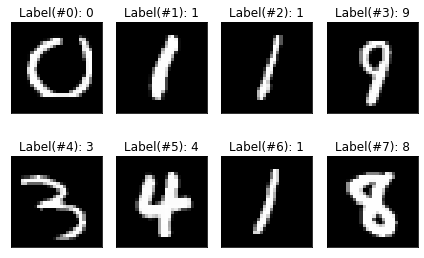

In [17]:
plot_batch(test_batch, targets)

## Private sharing of samples and labels

We're going to stick to CrypTens ABC naming "convention", so

- Alice = 0
- Bob = 1
- Carl = 2
- Daniel = 3
- ...

## Setup 1: Alice has samples, Bob has lables

Maybe this doesn't seem to applicable, but think of something like healthcare data instead:

- Alice has general data about a person
- Bob has diagnostic data about the patient

We'd like to learn how to predict the likelyhood of someone falling ill to a specific illness, but don't want to get in trouble with the EU over Data Privacy laws!

### Assign ranks to each participant

In [18]:
import pathlib
import shutil
import crypten.communicator as mpc_comm # the communicator is similar to the MPI communicator for example
from crypten import mpc

In [19]:
ALICE = 0
BOB = 1

participants = ["alice", "bob"]
num_participants = len(participants)
TMP_DIR = pathlib.Path("./TMP")
print(f"Our temporary data will land here: {TMP_DIR}")

def check_and_mkdir(directory:pathlib.Path):
    if not directory.exists():
        print("TMP_DIR created")
        directory.mkdir()
    
def rm_dir(directory:pathlib.Path):
    shutil.rmtree(directory)
    
check_and_mkdir(TMP_DIR)

Our temporary data will land here: TMP
TMP_DIR created


# Dealing with data

In [20]:
# Specify file locations to save each piece of data
filenames = {
    "samples": TMP_DIR / "features.pth",
    "labels": TMP_DIR / "labels.pth",
    "b_true": TMP_DIR / "b_true.pth",
    "test_samples": TMP_DIR / "test_samples.pth",
    "targets": TMP_DIR / "targets.pth",
    "w_true": TMP_DIR / "w_true.pth",
}

for u in participants:
    filenames["labels_"+u] = TMP_DIR / ("labels_" + u)
    filenames["samples_"+u] = TMP_DIR / ("samples_" + u)


In [21]:
def split_data(data, frac):
    length = data.shape[0]
    split_idx = int(length*frac)
    print(f"Returning: 0 <-1-> {split_idx} <-2->{length}")
    return data[:split_idx], data[split_idx:]

In [22]:
frac_alice = 0.6
frac_bob = 1 - frac_alice

@mpc.run_multiprocess(world_size=num_participants)
def save_all_data():
    
    print(f"Hello from {mpc_comm.get().get_rank()}")
    # Save features, labels for Data Labeling example
    crypten.save(train_data, filenames["samples"])
    crypten.save(labels, filenames["labels"])
    
    # Save split features for Feature Aggregation example
    data_alice, data_bob = split_data(data, frac_alice)
    labels_alice, labels_bob = split_data(targets, frac_alice)
    
    crypten.save(data_alice, filenames["samples_alice"], src=ALICE)
    crypten.save(data_bob, filenames["samples_bob"], src=BOB)
    
    # Save split dataset for Dataset Aggregation example
    crypten.save(labels_alice, filenames["labels_alice"], src=ALICE)
    crypten.save(labels_bob, filenames["labels_bob"], src=BOB)
    
    # Save true model weights and biases for Model Hiding example
    crypten.save(w_true, filenames["w_true"], src=ALICE)
    crypten.save(b_true, filenames["b_true"], src=ALICE)
    
    crypten.save(test_batch, filenames["test_samples"], src=BOB)
    crypten.save(targets, filenames["targets"], src=BOB)
    print(f"{mpc_comm.get().get_rank()} is done! Signing off...")
    
save_all_data()

Hello from 1Hello from 0



Process Process-1:
Traceback (most recent call last):
  File "/home/peter/.pyenv/versions/3.7.9/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/peter/.pyenv/versions/3.7.9/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/peter/.local/share/virtualenvs/Ex3-pG_9TV2D/lib/python3.7/site-packages/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "<ipython-input-22-fffc2aea0a0a>", line 9, in save_all_data
    crypten.save(train_data, filenames["samples"])
  File "/home/peter/.local/share/virtualenvs/Ex3-pG_9TV2D/lib/python3.7/site-packages/crypten/__init__.py", line 299, in save
    torch.save(obj, f, **kwargs)
  File "/home/peter/.local/share/virtualenvs/Ex3-pG_9TV2D/lib/python3.7/site-packages/torch/serialization.py", line 328, in save
    _legacy_save(obj, opened_file, pickle_module, pickle_protocol)
  File "/home/peter/

# Load and encrypt a model

*Note* that unlike loading a tensor, the result from crypten.load is not encrypted. Instead, **only** the *src* party's model is populated from the file. Why is explained below:

Once the model is loaded, we call the function from_pytorch: this function sets up a CrypTen network from the PyTorch network. It takes the *plaintext* network as input as well as dummy input. The dummy input must be a torch tensor of the same shape as a potential input to the network, however the values inside the tensor do not matter.

In [23]:
# Load model architecture
dummy_model = Net2()

# Load empty model
plaintext_model = dummy_model

# Load pre-trained model to Alice
#plaintext_model = crypten.load('models/tutorial4_alice_model.pth', dummy_model=dummy_model, src=ALICE)

In [24]:
# Encrypt the model from Alice:    

# 1. Create a dummy input with the same shape as the model input
# For MNIST: greyscale images of size 28x28 --> tensor(1, 1,28,28)
#                                                sample^  |-----| shape of image
dummy_input = torch.empty((1,1, 28, 28)) # Only shape matters!

# 2. Construct a CrypTen network with the trained model and dummy_input
private_model = crypten.nn.from_pytorch(plaintext_model, dummy_input)

# 3. Encrypt the CrypTen network with src=ALICE
private_model.encrypt(src=ALICE)

#Check that model is encrypted:
print("Model successfully encrypted:", private_model.encrypted)

Model successfully encrypted: True
